# requirements

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats

from src.load_data import load_data

fbirn_data, demographics = load_data()
timeseries = fbirn_data["data"]
diagnoses = fbirn_data["diags"]
sexes = fbirn_data["sexes"]
ages = fbirn_data["ages"]

print(demographics)
print(f"# subjects: {timeseries.shape[0]}, # timepoints: {timeseries.shape[1]}, # features: {timeseries.shape[2]}")

     Category          Statistic/Label   Value
0   Diagnosis             Count HC (0)  160.00
1   Diagnosis             Count SZ (1)  151.00
2         Sex           Count Male (0)  230.00
3         Sex         Count Female (1)   81.00
4         Age                      Min   18.00
5         Age                      Max   62.00
6         Age                     Mean   37.88
7         Age                  Std Dev   11.24
8    Age Bins  Count Bin 0 (18.0-32.7)  119.00
9    Age Bins  Count Bin 1 (32.7-47.3)  117.00
10   Age Bins  Count Bin 2 (47.3-62.0)   75.00
# subjects: 311, # timepoints: 140, # features: 53


In [3]:
ica_coords = pd.read_csv("data/ICN_coordinates.csv")
domains = ica_coords["Domain"]
# update nans with previous value
domains = domains.fillna(method='ffill')
domains = np.asarray(domains.tolist())

change_idx = np.flatnonzero(np.r_[True, domains[1:] != domains[:-1]])
# change_idx marks the start index of each group
starts = change_idx
# compute ends (inclusive) indices for each group
ends = np.r_[starts[1:] - 1, domains.size - 1]
centers = ((starts + ends) / 2.0).tolist()
# boundaries are positions between pixels: (end + 0.4) for each group except last
boundaries = (ends[:-1] + 0.4).tolist()

group_names_full = [domains[s] for s in starts]
group_names = ["SC", "AU", "SM", "VIS", "CC", "DM", "CB"]  # short names

/var/folders/c7/h35llrbd2h76sn_0f75rjyz00000gq/T/ipykernel_48122/2963762152.py:4: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  domains = domains.fillna(method='ffill')


# 0. First milestone
- Write a general setup for the experiments
- Find important features using stattests 
- Train classifiers, inspect the features that they found important

## derive PCC

In [4]:
from src.utils import corrcoef_batch

pcc_matrices = corrcoef_batch(timeseries)
pcc_matrices.shape

(311, 53, 53)

## run stat tests on the data

In [5]:
def ttest(data0, data1):
    stat, p_value = stats.ttest_ind(data0, data1, axis=0, equal_var=False)
    return stat, p_value

def analyze_group_differences(data, labels, stat_func = ttest):
    groups = np.unique(labels)
    group_data = [data[labels == g] for g in groups]

    stat, p_value = stat_func(group_data[0], group_data[1])
    p_thresh = (p_value < 0.05).astype(int)

    # # permutation-based p-values
    # n_perm = 5000
    # rng = np.random.RandomState(42)
    # all_data = np.concatenate(group_data, axis=0)
    # n1 = group_data[0].shape[0]
    # perm_stats = np.empty((n_perm,) + stat.shape)

    # for i in range(n_perm):
    #     idx = rng.permutation(all_data.shape[0])
    #     g0 = all_data[idx[:n1]]
    #     g1 = all_data[idx[n1:]]
    #     tperm, _ = stats.ttest_ind(g0, g1, axis=0, equal_var=False)
    #     perm_stats[i] = tperm

    # perm_p = (np.sum(np.abs(perm_stats) >= np.abs(stat), axis=0) + 1) / (n_perm + 1)
    # perm_p[np.isnan(stat)] = np.nan
    # p_value_perm = perm_p

    return stat, p_value, p_thresh

def plot_heatmap(matrix, ax, cmap='bwr', vmin=None, vmax=None, guides_color='k'):
    cax = ax.imshow(matrix, cmap=cmap, vmin=vmin, vmax=vmax)
    ax.set_xticks(centers)
    ax.set_xticklabels(group_names)
    ax.set_yticks(centers)
    ax.set_yticklabels(group_names)
    for boundary in boundaries:
        ax.axhline(boundary, color=guides_color, linewidth=1.5)
        ax.axvline(boundary, color=guides_color, linewidth=1.5)
    return cax

def plot_stats(stat, p_vals, p_thresh):
    fig, ax = plt.subplots(1, 3, figsize=(14, 5))
    cax1 = plot_heatmap(stat, ax[0], vmin=-5, vmax=5)
    ax[0].set_title("T-statistics")
    fig.colorbar(cax1, ax=ax[0], fraction=0.045)  

    cax2 = plot_heatmap(p_vals, ax[1], vmin=0, vmax=1, cmap='inferno_r')
    ax[1].set_title("p-values")
    fig.colorbar(cax2, ax=ax[1], fraction=0.045)  

    cax3 = plot_heatmap(p_thresh, ax[2], vmin=0, vmax=1, cmap='inferno')
    ax[2].set_title("Significant p < 0.05")
    cbar3 = fig.colorbar(cax3, ax=ax[2], fraction=0.045)
    cbar3.set_ticks([0, 1])
    cbar3.set_ticklabels(['False', 'True'])

    plt.tight_layout()
    plt.show()

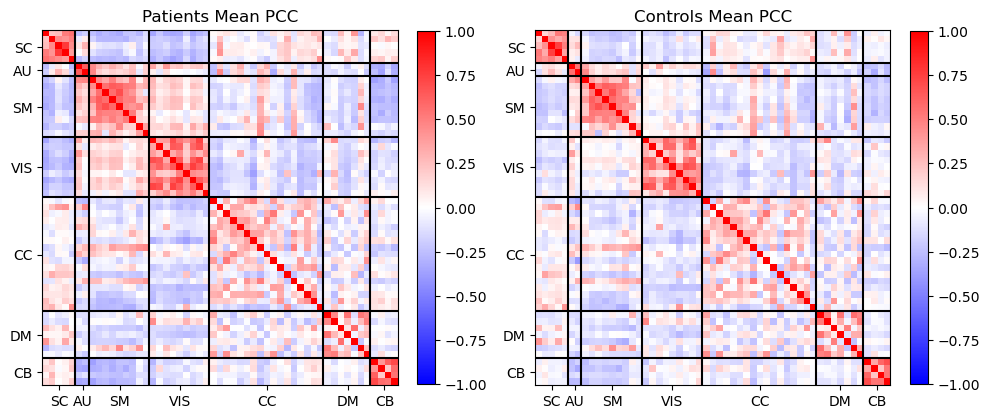

In [6]:
# plot means

groups = np.unique(diagnoses)
group_data = [pcc_matrices[diagnoses == g] for g in groups]
means = [np.mean(gd, axis=0) for gd in group_data]

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
cax = plot_heatmap(means[0], ax[0], cmap='bwr', vmin=-1, vmax=1)
fig.colorbar(cax, ax=ax[0], fraction=0.045)
ax[0].set_title("Patients Mean PCC")
cax = plot_heatmap(means[1], ax[1], cmap='bwr', vmin=-1, vmax=1)
fig.colorbar(cax, ax=ax[1], fraction=0.045)
ax[1].set_title("Controls Mean PCC")
plt.tight_layout()
plt.show()

/Users/ppopov1/miniconda3/envs/pile/lib/python3.12/site-packages/scipy/stats/_axis_nan_policy.py:611: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, axis=axis, **kwds)


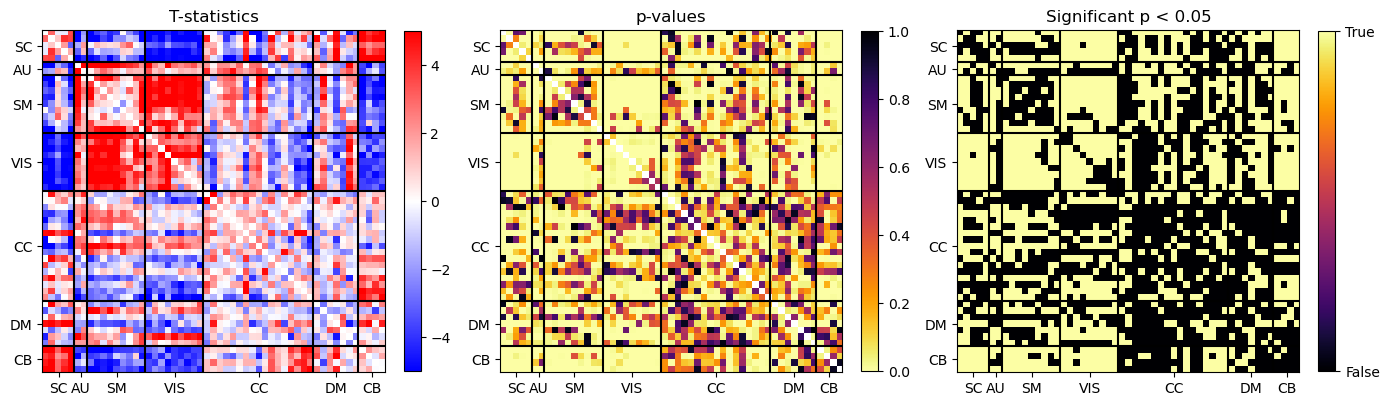

Proportion of significant connections: 0.5148


In [7]:
stat, p_value, p_thresh = analyze_group_differences(pcc_matrices, diagnoses)
plot_stats(stat, p_value, p_thresh)

# compute True rate in p_thresh; I will use it as a threhold for ML feature importance selection
r_significant = np.sum(p_thresh)/np.size(p_thresh)
print(f"Proportion of significant connections: {r_significant:.4f}")

## use ML to find predictive features

In [8]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance

def forest_features(X, y, n_estimators=2000, threshold=0.5):
    C = X.shape[1]
    tril_indices = np.tril_indices(X.shape[1], k=-1)
    X = X[:, tril_indices[0], tril_indices[1]]
    n_samples = X.shape[0]
    X = X.reshape(n_samples, -1)

    clf = RandomForestClassifier(n_estimators=n_estimators)
    clf.fit(X, y)
    importances = clf.feature_importances_

    # reshape importances back to matrix form
    full_importances = np.zeros((C, C))
    full_importances[tril_indices] = importances
    full_importances = full_importances + full_importances.T
    importances = full_importances

    # get a mask of top k% importances
    # topk_importances = np.percentile(importances, 100 * threshold)
    topk_importances = np.percentile(importances, 100 * (1-threshold))
    mask = importances > topk_importances

    return importances, mask

In [9]:
importances, importance_mask = forest_features(pcc_matrices, diagnoses, threshold=r_significant)

/var/folders/c7/h35llrbd2h76sn_0f75rjyz00000gq/T/ipykernel_48122/809358486.py:5: RuntimeWarning: divide by zero encountered in log
  cax = plot_heatmap(np.log(importances), ax[1], cmap='inferno', guides_color='white')


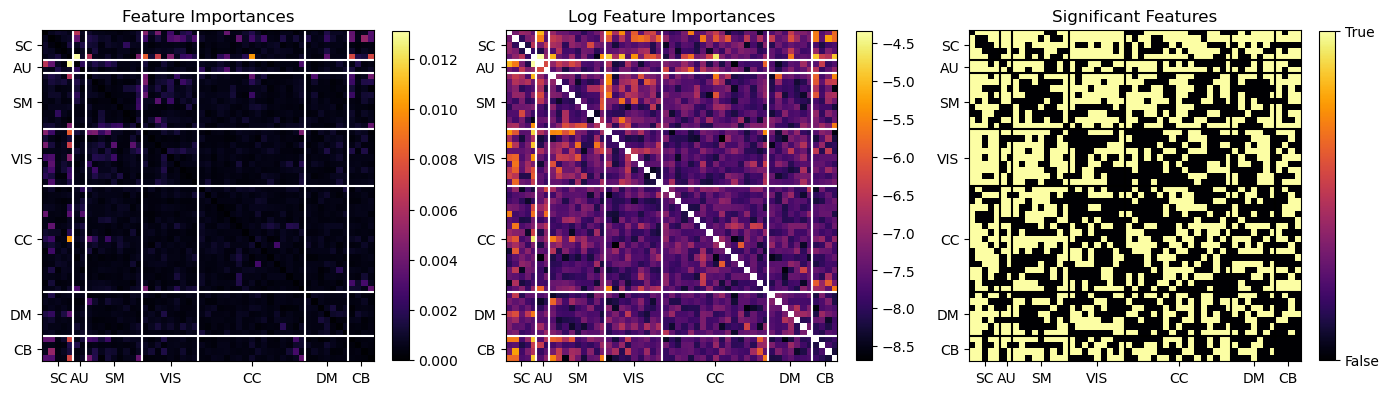

In [10]:
fig, ax = plt.subplots(1, 3, figsize=(14, 5))
cax = plot_heatmap(importances, ax[0], cmap='inferno', guides_color='white')
fig.colorbar(cax, ax=ax[0], fraction=0.045)
ax[0].set_title("Feature Importances")
cax = plot_heatmap(np.log(importances), ax[1], cmap='inferno', guides_color='white')
fig.colorbar(cax, ax=ax[1], fraction=0.045)
ax[1].set_title("Log Feature Importances")

cax = plot_heatmap(importance_mask, ax[2], cmap='inferno')
ax[2].set_title("Significant Features")
cbar3 = fig.colorbar(cax, ax=ax[2], fraction=0.045)
cbar3.set_ticks([0, 1])
cbar3.set_ticklabels(['False', 'True'])
plt.tight_layout()
plt.show()

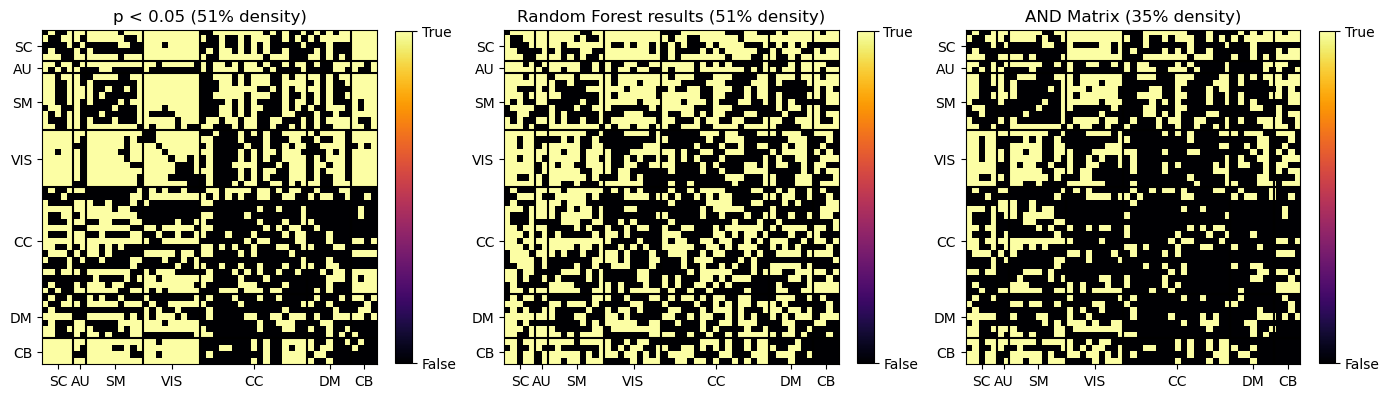

In [11]:
# plot p_thresh and importance_mask, and AND matrix
fig, ax = plt.subplots(1, 3, figsize=(14, 5))
cax1 = plot_heatmap(p_thresh, ax[0], cmap='inferno')
sp_p = np.sum(p_thresh)/np.size(p_thresh)
ax[0].set_title(f"p < 0.05 ({int(sp_p*100)}% density)")
cbar1 = fig.colorbar(cax1, ax=ax[0], fraction=0.045)
cbar1.set_ticks([0, 1])
cbar1.set_ticklabels(['False', 'True'])

cax2 = plot_heatmap(importance_mask, ax[1], cmap='inferno')
sp_rf = np.sum(importance_mask)/np.size(importance_mask)
ax[1].set_title(f"Random Forest results ({int(sp_rf*100)}% density)")
cbar2 = fig.colorbar(cax2, ax=ax[1], fraction=0.045)
cbar2.set_ticks([0, 1])
cbar2.set_ticklabels(['False', 'True'])

and_matrix = p_thresh & importance_mask
sp_and = np.sum(and_matrix)/np.size(and_matrix)
cax3 = plot_heatmap(and_matrix, ax[2], cmap='inferno')
ax[2].set_title(f"AND Matrix ({int(sp_and*100)}% density)")
cbar3 = fig.colorbar(cax3, ax=ax[2], fraction=0.045)
cbar3.set_ticks([0, 1])
cbar3.set_ticklabels(['False', 'True'])
plt.tight_layout()
plt.show()

### compare classification scores with different subsets of predictive features 

# More statistics

I will use pyspi to compute statistics. Check their docummentation: https://time-series-features.gitbook.io/pyspi/installing-and-using-pyspi/usage/walkthrough-tutorials/getting-started-a-simple-demonstration

In [12]:
timeseries[0].T.shape

(53, 140)

In [13]:

from pyspi.calculator import Calculator

stats = []

test_subject = timeseries[0].T # pyspi calc expects data in shape [chanels, time]
calc = Calculator(dataset=test_subject, subset='fast') # instantiate the calculator object

Checking if optional dependencies exist...
octave not found, please see README
Octave not available: octave not found, please see README
Starting JVM with java class /Users/ppopov1/miniconda3/envs/pile/lib/python3.12/site-packages/pyspi/lib/jidt/infodynamics.jar.
Jpype JVM not available: [Errno 2] JVM DLL not found: /Library/Java/JavaVirtualMachines/temurin-17.jdk/Contents/MacOS/libjli.dylib
Loading configuration file: /Users/ppopov1/miniconda3/envs/pile/lib/python3.12/site-packages/pyspi/fast_config.yaml
*** Importing module .statistics.basic
[0] Adding SPI .statistics.basic.Covariance(x,y,{'estimator': 'EmpiricalCovariance'})
Succesfully initialised SPI with identifier "cov_EmpiricalCovariance" and labels ['basic', 'unordered', 'linear', 'undirected', 'signed']
[1] Adding SPI .statistics.basic.Covariance(x,y,{'estimator': 'GraphicalLasso'})
Succesfully initialised SPI with identifier "cov_GraphicalLasso" and labels ['basic', 'unordered', 'linear', 'undirected', 'signed']
[2] Adding S

No GPU automatically detected. Setting SETTINGS.GPU to 0, and SETTINGS.NJOBS to cpu_count.


[46] Adding SPI .statistics.causal.AdditiveNoiseModel(x,y)...
Succesfully initialised SPI with identifier "anm" and labels ['unsigned', 'causal', 'unordered', 'linear', 'directed']
[47] Adding SPI .statistics.causal.ConditionalDistributionSimilarity(x,y)...
Succesfully initialised SPI with identifier "cds" and labels ['unsigned', 'causal', 'unordered', 'nonlinear', 'directed']
[48] Adding SPI .statistics.causal.RegressionErrorCausalInference(x,y)...
Succesfully initialised SPI with identifier "reci" and labels ['unsigned', 'causal', 'unordered', 'nonlinear', 'directed']
[49] Adding SPI .statistics.causal.InformationGeometricConditionalIndependence(x,y)...
Succesfully initialised SPI with identifier "igci" and labels ['causal', 'directed', 'nonlinear', 'unsigned', 'unordered']
*** Importing module .statistics.infotheory
Optional dependencies: ['java'] not met. Skipping 3 SPI(s):
*SKIPPING SPI: .statistics.infotheory.JointEntropy(x,y,{'estimator': 'gaussian'})...
*SKIPPING SPI: .statisti

Frequency minimum set to 0; overriding to 1e-5.


Succesfully initialised SPI with identifier "sgc_nonparametric_mean_fs-1_fmin-0_fmax-0-5" and labels ['unsigned', 'embedding', 'spectral', 'directed', 'lagged']
[141] Adding SPI .statistics.spectral.SpectralGrangerCausality(x,y,{'method': 'nonparametric', 'fmin': 0, 'fmax': 0.25, 'statistic': 'mean'})
Succesfully initialised SPI with identifier "sgc_nonparametric_mean_fs-1_fmin-0_fmax-0-25" and labels ['unsigned', 'embedding', 'spectral', 'directed', 'lagged']
[142] Adding SPI .statistics.spectral.SpectralGrangerCausality(x,y,{'method': 'nonparametric', 'fmin': 0.25, 'fmax': 0.5, 'statistic': 'mean'})
Succesfully initialised SPI with identifier "sgc_nonparametric_mean_fs-1_fmin-0-25_fmax-0-5" and labels ['unsigned', 'embedding', 'spectral', 'directed', 'lagged']
[143] Adding SPI .statistics.spectral.SpectralGrangerCausality(x,y,{'method': 'nonparametric', 'fmin': 0, 'fmax': 0.5, 'statistic': 'max'})
Succesfully initialised SPI with identifier "sgc_nonparametric_max_fs-1_fmin-0_fmax-0-5

'cgi' is deprecated and slated for removal in Python 3.13


[164] Adding SPI .statistics.wavelet.PhaseSlopeIndex(x,y,{'fs': 1})
Succesfully initialised SPI with identifier "psi_wavelet_mean_fs-1_fmin-0_fmax-0-5_mean" and labels ['unsigned', 'wavelet', 'undirected']
[165] Adding SPI .statistics.wavelet.PhaseSlopeIndex(x,y,{'fmin': 0, 'fmax': 0.25})
Succesfully initialised SPI with identifier "psi_wavelet_mean_fs-1_fmin-0_fmax-0-25_mean" and labels ['unsigned', 'wavelet', 'undirected']
[166] Adding SPI .statistics.wavelet.PhaseSlopeIndex(x,y,{'fmin': 0.25, 'fmax': 0.5})
Succesfully initialised SPI with identifier "psi_wavelet_mean_fs-1_fmin-0-25_fmax-0-5_mean" and labels ['unsigned', 'wavelet', 'undirected']
[167] Adding SPI .statistics.wavelet.PhaseSlopeIndex(x,y,{'fmin': 0, 'fmax': 0.5, 'statistic': 'max'})
Succesfully initialised SPI with identifier "psi_wavelet_max_fs-1_fmin-0_fmax-0-5_max" and labels ['unsigned', 'wavelet', 'undirected']
[168] Adding SPI .statistics.wavelet.PhaseSlopeIndex(x,y,{'fmin': 0, 'fmax': 0.25, 'statistic': 'max'})
S

In [14]:
calc.compute()

Processing [None: phase_multitaper_mean_fs-1_fmin-0_fmax-0-5]:  26%|██▌       | 50/192 [42:07<6:38:16, 168.28s/it]Caught <class 'ValueError'> for SPI "phase_multitaper_mean_fs-1_fmin-0_fmax-0-5": Expected 3D array with shape (n_time_samples, n_trials, n_signals), but got 2D array with shape (140, 53).

For 2D data, you must clarify the meaning of the second dimension.

Use prepare_time_series() helper:
  >>> from spectral_connectivity.transforms import prepare_time_series
  >>> # If shape is (n_time, n_signals) with 1 trial:
  >>> time_series_3d = prepare_time_series(time_series, axis='signals')
  >>> # If shape is (n_time, n_trials) with 1 signal:
  >>> time_series_3d = prepare_time_series(time_series, axis='trials')

Or manually with np.newaxis:
  >>> # For (n_time, n_signals) → (n_time, 1, n_signals):
  >>> time_series_3d = time_series[:, np.newaxis, :]
  >>> # For (n_time, n_trials) → (n_time, n_trials, 1):
  >>> time_series_3d = time_series[:, :, np.newaxis]
Processing [None: phas


Calculation complete. Time taken: 2543.4234s

SPI Computation Results Summary

Total number of SPIs attempted: 192
Number of SPIs successfully computed: 96 (50.00%)
------------------------------------------------------------
Category       | Count | Percentage
------------------------------------------------------------
Successful     |    96 |  50.00%
NaNs           |    96 |  50.00%
Partial NaNs   |     0 |   0.00%
------------------------------------------------------------

[96] SPI(s) produced NaN outputs:
------------------------------------------------------------
1. phase_multitaper_mean_fs-1_fmin-0_fmax-0-5
2. phase_multitaper_mean_fs-1_fmin-0_fmax-0-25
3. phase_multitaper_mean_fs-1_fmin-0-25_fmax-0-5
4. phase_multitaper_max_fs-1_fmin-0_fmax-0-5
5. phase_multitaper_max_fs-1_fmin-0_fmax-0-25
6. phase_multitaper_max_fs-1_fmin-0-25_fmax-0-5
7. cohmag_multitaper_mean_fs-1_fmin-0_fmax-0-5
8. cohmag_multitaper_mean_fs-1_fmin-0_fmax-0-25
9. cohmag_multitaper_mean_fs-1_fmin-0-25_fma

In [36]:
counter = 0

for spi_type in calc.spis:
    spi_data = calc.table["cov_EmpiricalCovariance"].to_numpy()
    # get values off-diagonal
    off_diag = spi_data[np.triu_indices_from(spi_data, k=1)]
    nans_off_diag = np.isnan(off_diag).any()
    if not nans_off_diag:
        counter += 1
    else:
        print(F"{spi_type} data has nans off-diagonal: {nans_off_diag}")

print(F"Number of SPI types without nans off-diagonal: {counter} out of {len(calc.spis)}")

Number of SPI types without nans off-diagonal: 192 out of 192


In [ ]:
calc.table["cov_EmpiricalCovariance"]
calc.table["cov_EmpiricalCovariance"].to_numpy().shape

process,proc-0,proc-1,proc-2,proc-3,proc-4,proc-5,proc-6,proc-7,proc-8,proc-9,...,proc-43,proc-44,proc-45,proc-46,proc-47,proc-48,proc-49,proc-50,proc-51,proc-52
proc-0,NaN,-0.112024,0.361426,0.629223,0.268034,0.019006,-0.010378,0.126076,-0.002620,-0.076704,...,-0.229658,0.641106,0.343171,0.794112,-0.069697,0.159885,-0.525332,-0.425624,-0.529221,-0.320069
proc-1,-0.112024,NaN,0.476841,0.384182,0.311437,0.549623,0.485919,0.385439,0.045409,0.059358,...,-0.140256,-0.149331,-0.194016,0.026014,-0.440817,-0.110637,0.072716,0.077301,0.148096,-0.225861
proc-2,0.361426,0.476841,NaN,0.883128,0.475279,0.682606,0.691781,0.622176,0.181650,-0.053063,...,-0.354634,0.290915,-0.022177,0.373025,-0.367840,-0.016898,-0.281504,-0.403775,-0.105154,-0.427980
proc-3,0.629223,0.384182,0.883128,NaN,0.420503,0.570264,0.559704,0.532386,0.158870,-0.064773,...,-0.403567,0.513900,0.091960,0.653743,-0.313165,0.035515,-0.429139,-0.478518,-0.296128,-0.474305
proc-4,0.268034,0.311437,0.475279,0.420503,NaN,0.553681,0.201143,0.341116,0.399219,0.229612,...,-0.052430,0.260651,0.240487,0.204727,0.104702,0.234183,-0.295077,-0.173012,-0.207240,-0.217683
proc-5,0.019006,0.549623,0.682606,0.570264,0.553681,NaN,0.768063,0.569307,0.254364,0.161638,...,-0.226670,0.135202,-0.102345,0.140523,-0.161175,0.017783,-0.203501,-0.198433,-0.057543,-0.389498
proc-6,-0.010378,0.485919,0.691781,0.559704,0.201143,0.768063,NaN,0.729659,0.090473,-0.029093,...,-0.250008,0.148064,-0.176069,0.152882,-0.295551,-0.078518,-0.097968,-0.243818,0.100818,-0.312695
proc-7,0.126076,0.385439,0.622176,0.532386,0.341116,0.569307,0.729659,NaN,0.261513,-0.073919,...,-0.242053,0.154960,0.056922,0.150088,-0.307390,0.067829,-0.173450,-0.188199,-0.006249,-0.317386
proc-8,-0.002620,0.045409,0.181650,0.158870,0.399219,0.254364,0.090473,0.261513,NaN,0.420052,...,-0.224914,-0.051056,0.076495,0.000005,0.023940,-0.015380,-0.110063,-0.026022,-0.150530,-0.085174
proc-9,-0.076704,0.059358,-0.053063,-0.064773,0.229612,0.161638,-0.029093,-0.073919,0.420052,NaN,...,-0.043850,-0.095815,-0.064189,-0.094592,0.219574,-0.049962,-0.040810,0.128466,-0.053733,-0.047927
